# Алгоритмы K-ближайших соседей и K-средних на Python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Загрузим секретные данные, где каждый столбец означает неизвестно что
raw_data = pd.read_csv('k-NN_classified_data.csv')

In [4]:
raw_data.head()

,Unnamed: 0,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [6]:
# Избавимся от безымянного столбца
raw_data = pd.read_csv('k-NN_classified_data.csv', index_col = 0)

In [7]:
raw_data.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [8]:
raw_data.columns

Index(['WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF', 'HQE', 'NXJ',
       'TARGET CLASS'],
      dtype='object')

## Стандартизация датасета

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [12]:
# Обучаем scaler на нашем датасете, используя метод fit:
scaler.fit(raw_data.drop('TARGET CLASS', axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
# Масштабируем фичи, чтобы они имели примерно одинаковый масштаб.
scaled_features = scaler.transform(raw_data.drop('TARGET CLASS', axis=1))

In [14]:
# Оборачиваю 
scaled_data = pd.DataFrame(scaled_features, columns = raw_data.drop('TARGET CLASS', axis=1).columns)

In [15]:
scaled_data.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


In [16]:
from sklearn.model_selection import train_test_split

x = scaled_data
y = raw_data['TARGET CLASS']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

# Обучение модели K-ближайших соседей

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# Для начала укажем n_neighbors = 1
model = KNeighborsClassifier(n_neighbors = 1)

In [19]:
model.fit(x_training_data, y_training_data)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [20]:
predictions = model.predict(x_test_data)

## Оценка точности нашей модели

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [22]:
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       143
           1       0.94      0.92      0.93       157

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [23]:
# Матрица ошибок:
print(confusion_matrix(y_test_data, predictions))

[[134   9]
 [ 12 145]]


## Выбор оптимального значения для K с помощью метода «Локтя»

Метод локтя включает в себя итерацию по различным значениям K и выбор значения с наименьшей частотой ошибок при применении к нашим тестовым данным.

In [24]:
# Для начала создадим пустой список error_rates.
# Мы пройдемся по различным значениям K и добавим их частоту ошибок в этот список.
error_rates = []

In [25]:
# перебор k от 1 до 100
for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))

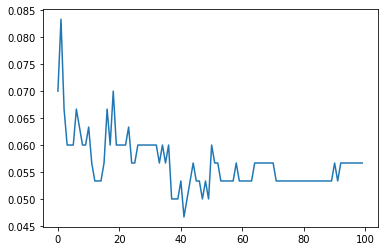

In [26]:
plt.plot(error_rates)

Видно, что минимум ошибок достигается при k примерно равным 40

Источник:
https://pythonru.com/uroki/sklearn-kmeans-i-knn